# Text Classification using Logistic Regression


## Problem statement¶
The goal of this project is to predict whether a comment is sarcastic or not based on 1 million comments scrapped from Reddit - also called sub-reddits. This means, we are facing a binary classification problem that involves incorporating NLP techniques to feed to our ML/DL models.

## Goal of this notebook
Our goal is to build a model to predict the comment's label (sarcastic or not). In this notebook, we will use logistic regression and TfidfVectorizer - that transforms text to feature vectors that can be used as input to estimator - in order to perform this task. Why using logistic regression? It is fast and relatively uncomplicated, and it’s convenient for you to interpret the results.

## Structure of this notebook
0. Set-up and data cleansing
1. Modelling (4 cases using combinations of comment and parent + with/without cleaning data)
- Create datasets and clean data when necessary
- Modelling
- Evaluation
2. Conclusions

# 0. Set-up

In [3]:
###################################################################################################
###
### Install all the necessary packages 
###
###################################################################################################

!pip install -r requirements_logit.txt

ERROR! Session/line number was not unique in database. History logging moved to new session 146


In [4]:
###################################################################################################
###
### Import all the necessary packages and custom functions (from the functions.py file)
###
###################################################################################################

import time
import os
import numpy as np
import pandas as pd
import itertools
import pickle

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold

from functions import *

In [5]:
###################################################################################################
###
### Get the data from the Google Drive public folders
###
###################################################################################################

# Load train and test dataframes
test_df = get_sarcasm_test_df()
train_df = get_sarcasm_train_df()

# 1. Modelling

## 1.1. Logistic Regression on 'comment' field without data cleaning

In this case, we will use 'comment' as the text input field for the model. Moreover, this section describes the process in a detailed way, whilst the following modelling cases using logistic regression are condensed in order not to repeat the descriptions and save time and attention.

In [6]:
###################################################################################################
###
### Prepare the datasets for the model
###
###################################################################################################

# Initiate
start_time = time.time()

# Keep only the necessary columns
test_df_model = test_df[['id', 'label', 'comment']].dropna()
train_df_model = train_df[['id', 'label', 'comment']].dropna()

# Set training dataset
X_train = train_df_model['comment']
Y_train = train_df_model['label']

# Set test dataset
X_test = test_df_model['comment']
Y_test = test_df_model['label']

# Show how does the dataframe look like
train_df_model.head()

,id,label,comment
0,1,0,"""""I like my shortstops how I like my beef... i..."
1,2,1,He works in mysterious ways
2,3,0,You're right
3,4,0,Is this amount of meat in the ratio of meat to...
4,5,0,You can hug and kiss my ass X and O


### TFIDF(Term Frequency — Inverse Document Frequency)

Term Frequency Inverse Document Frequency (TFIDF) analysis is one of the simple and robust methods to understand the context of a text. Term Frequency and Inverse Document Frequency is used to find the related content and important words and phrases in a larger text. Computers cannot understand the meaning of a text, but they can understand numbers. The words can be converted to numbers so that the relationship between them can be understood.


In [7]:
###################################################################################################
###
### Set up our text vectorisation and our model
###
###################################################################################################

# Transforming our text fields by quantifying the relevance of string representations. We will
#  set up the vectorizer considering unigrams (1,1) and bigrams (2,2) and ignoring terms that 
#  have a document frequency strictly lower than 2
tf_idf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)

### Logistic Regression

Logistic Regression is an efective algorithm to classify text, widely use in NLP tasks. Moreover, it is quite fast performance-wise, it is very solid and it is easy to interpret

In [8]:
# Initiate logistic regression for modelling. For the lbfgs solvers set verbose to any positive 
#   number for verbosity.
logit = LogisticRegression(n_jobs=4, solver='lbfgs', verbose=1, max_iter=1000000)


# Apply TF-IDF to our train and test text fields
X_train_transformed = tf_idf.fit_transform(X_train)
X_test_transformed = tf_idf.transform(X_test)

In [9]:
###################################################################################################
###
### Train our model and predict over the test dataset
###
###################################################################################################

# Train the train dataset with Logistic Regression
logit.fit(X_train_transformed, Y_train)

# Predict labels (is the comment sarcastic or not) on the test dataset
predictions_values = logit.predict(X_test_transformed)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       614479     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30554D+05    |proj g|=  1.42109D+03


 This problem is unconstrained.



At iterate   50    f=  4.77369D+05    |proj g|=  3.16091D+02

At iterate  100    f=  4.68645D+05    |proj g|=  2.59817D+02

At iterate  150    f=  4.67494D+05    |proj g|=  5.84892D+01

At iterate  200    f=  4.67112D+05    |proj g|=  1.93807D+02

At iterate  250    f=  4.67027D+05    |proj g|=  3.63836D+01

At iterate  300    f=  4.67022D+05    |proj g|=  2.56649D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    339    413      1     0     0   1.859D+01   4.670D+05
  F =   467021.33874609205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   57.0s finished


### Evaluating the results of our model

The logistic regression model predicts correctly 72.72 percent of the Reddit comments


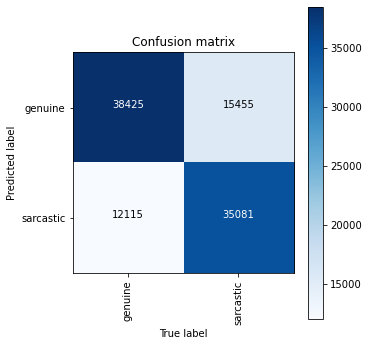

In [10]:
###################################################################################################
###
### Evaluate the results
###
################################################################################################### 
        

# Inidicate when it finishes
end_time = time.time()

# Check the accuracy of the model
accuracy_score(Y_test, predictions_values)
print("The logistic regression model predicts correctly %.2f percent of the Reddit comments"%(accuracy_score(Y_test, predictions_values)*100))

# Plot the confusion matrix
plot_confusion_matrix(Y_test, predictions_values, ['genuine','sarcastic'], figsize=(5, 5))

In [11]:
# Show results on the classification report
print(classification_report(Y_test, predictions_values))

print("Our model predicts slightly worse the sarcastic comments (0.72), but there is not a large deviation")

              precision    recall  f1-score   support

           0       0.71      0.76      0.74     50540
           1       0.74      0.69      0.72     50536

    accuracy                           0.73    101076
   macro avg       0.73      0.73      0.73    101076
weighted avg       0.73      0.73      0.73    101076

Our model predicts slightly worse the sarcastic comments (0.72), but there is not a large deviation


Our model provided an AUC score of 0.73 , meaning, that the model is not optimal, but on an acceptable range
The more far left the curve is, the better our model. We can adjust our threshold based on our ROC curve to get results based on model requirements


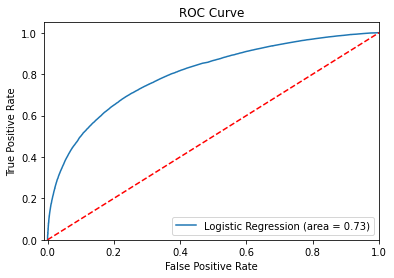

In [12]:
#In general, an AUC of 0.5 suggests no discrimination (i.e., ability to classify a comment 
#  with and without knowing the condition), 0.7 to 0.8 is considered acceptable, 0.8 to 0.9 
#  is considered excellent and more than 0.9 is considered outstanding")

print("Our model provided an AUC score of", round(roc_auc_score(Y_test, logit.predict(X_test_transformed)),2), ", meaning, that the model is not optimal, but on an acceptable range")
print("The more far left the curve is, the better our model. We can adjust our threshold based on our ROC curve to get results based on model requirements") 
    
# Set up visualization for the ROC curve
logit_roc_auc = roc_auc_score(Y_test, logit.predict(X_test_transformed))
fpr, tpr, thresholds = roc_curve(Y_test, logit.predict_proba(X_test_transformed)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
###################################################################################################
###
### Store the results
###
###################################################################################################

# Store the final results from the logistic regression model without cleaning (since it was our best performer)
logit_results = pd.DataFrame({'id': test_df_model.id, 'predicted': predictions_values})
logit_results.to_csv("log_reg_results.csv")

# Store the results for comparison
score = round(accuracy_score(Y_test, predictions_values),2)
model_name = 'log_reg_comment_only_without_cleaning'

# Create a comparison table to append the results
comparison_table = pd.DataFrame([[model_name, score, round(end_time - start_time,0)]], columns = ['Model', 'Accuracy', 'Execution_Time_Seconds'])


In [14]:
###################################################################################################
###
### Save our trained model to file and load it later in order to make predictions
###
###################################################################################################


# Save the model to disk
model_saved = 'logistic_regression_model_sarcasm.sav'
pickle.dump(logit, open(model_saved, 'wb'))
 
# Load the model from disk
model_saved = 'logistic_regression_model_sarcasm.sav'
loaded_log_regression = pickle.load(open(model_saved, 'rb'))

# Show accuracy score from our model
print("Our model accuracy is ", round(loaded_log_regression.score(X_test_transformed, Y_test),2))

# Show predictions from loaded our model
print("Some results of our prediction (labels): " ,loaded_log_regression.predict(X_test_transformed))

Our model accuracy is  0.73
Some results of our prediction (labels):  [1 0 1 ... 0 0 0]


## 1.2. Logistic Regression on 'comment' + 'parent_comment' fields without data cleaning

In this case, we will use 'comment' and 'parent_comment' as the text input field for the model, in order to understand if this approach provides higher accuracy

In [12]:
###################################################################################################
###
### Prepare the datasets for the model
###
###################################################################################################

# Initiate
start_time = time.time()

# Set datasets
train_df_model = train_df
test_df_model = test_df

# Create column with comment and parent comment text together. This will become the field to model over
train_df_model['comment_and_parent_comment'] = train_df_model['comment'] + ' ' + train_df_model['parent_comment'] 
train_df_model = train_df_model[['id', 'label', 'comment_and_parent_comment']].dropna()

# Create column with comment and parent comment text together. This will become the field to model over
test_df_model['comment_and_parent_comment'] = test_df_model['comment'] + ' ' + test_df_model['parent_comment'] 
test_df_modelt_df = test_df_model[['id', 'label', 'comment_and_parent_comment']].dropna()

# Keep only the necessary columns
test_df_model = test_df[['id', 'label', 'comment_and_parent_comment']].dropna()
train_df_model = train_df[['id', 'label', 'comment_and_parent_comment']].dropna()

# Set training dataset
X_train = train_df_model['comment_and_parent_comment']
Y_train = train_df_model['label']

# # Set test dataset
X_test = test_df_model['comment_and_parent_comment']
Y_test = test_df_model['label']

# Show how does the dataframe look like
train_df_model.head()


###################################################################################################
###
### Train our model and predict over the test dataset
###
###################################################################################################


# Initiate logistic regression for modelling
logit = LogisticRegression(n_jobs=4, solver='lbfgs', verbose=1, max_iter=1000000)

# Apply TF-IDF to our train and test text fields
X_train_transformed = tf_idf.fit_transform(X_train)
X_test_transformed = tf_idf.transform(X_test)

# Train the model
logit.fit(X_train_transformed, Y_train)

# Predict labels (is the comment sarcastic or not) on the test dataset
predictions_values = logit.predict(X_test_transformed)

# Inidicate when it finishes
end_time = time.time()

# Check the accuracy of the model
accuracy_score(Y_test, predictions_values)
print("The logistic regression model predicts correctly %.2f percent of the Reddit comments"%(accuracy_score(Y_test, predictions_values)*100))


###################################################################################################
###
### Store the results
###
###################################################################################################

# Store the results for comparison
score = round(accuracy_score(Y_test, predictions_values),2)
model_name = 'log_reg_comment_with_parent_without_cleaning'
df_new_comparison = pd.DataFrame([[model_name, score, round(end_time - start_time,0)]], columns = ['Model', 'Accuracy', 'Execution_Time_Seconds'])

# Append the results to the final comparison table
comparison_table = comparison_table.append(df_new_comparison)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      1768994     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30554D+05    |proj g|=  7.73580D+02


 This problem is unconstrained.



At iterate   50    f=  4.95498D+05    |proj g|=  3.72044D+02

At iterate  100    f=  4.91503D+05    |proj g|=  7.51449D+01

At iterate  150    f=  4.91306D+05    |proj g|=  4.63508D+02

At iterate  200    f=  4.91231D+05    |proj g|=  1.90695D+02

At iterate  250    f=  4.91201D+05    |proj g|=  1.88876D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    264    313      1     0     0   5.462D+00   4.912D+05
  F =   491200.78147815133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The logistic regression model predicts correctly 69.11 percent of the Reddit comments


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  2.0min finished


## 1.3. Logistic Regression on 'comment' field with data cleaning

In this case, we will use 'comment' as the text input field for the model

In [13]:
###################################################################################################
###
### Prepare the datasets for the model
###
###################################################################################################

# Initiate
start_time = time.time()

# Keep only the necessary columns
test_df_model = test_df[['id', 'label', 'comment']].dropna()
train_df_model = train_df[['id', 'label', 'comment']].dropna()

# Set training dataset
X_train = train_df_model['comment']
Y_train = train_df_model['label']

# Set test dataset
X_test = test_df_model['comment']
Y_test = test_df_model['label']

# Apply cleaning functions (functions.py) to our text data
test_df_model['comment'] =  test_df_model['comment'].apply(replace_contractions).apply(basic_cleaning).apply(remove_stopwords)
train_df_model['comment'] =  train_df_model['comment'].apply(replace_contractions).apply(basic_cleaning).apply(remove_stopwords)

# Show how does the dataframe look like
train_df_model.head()


###################################################################################################
###
### Train our model and predict over the test dataset
###
###################################################################################################


# Initiate logistic regression for modelling
logit = LogisticRegression(n_jobs=4, solver='lbfgs', verbose=1, max_iter=1000000)

# Apply TF-IDF to our train and test text fields
X_train_transformed = tf_idf.fit_transform(X_train)
X_test_transformed = tf_idf.transform(X_test)

# Train the model
logit.fit(X_train_transformed, Y_train)

# Predict labels (is the comment sarcastic or not) on the test dataset
predictions_values = logit.predict(X_test_transformed)

# Inidicate when it finishes
end_time = time.time()

# Check the accuracy of the model
accuracy_score(Y_test, predictions_values)
print("The logistic regression model predicts correctly %.2f percent of the Reddit comments"%(accuracy_score(Y_test, predictions_values)*100))


###################################################################################################
###
### Store the results
###
###################################################################################################

# Store the results for comparison
score = round(accuracy_score(Y_test, predictions_values),2)
model_name = 'log_reg_comment_only_with_cleaning'
df_new_comparison = pd.DataFrame([[model_name, score, round(end_time - start_time,0)]], columns = ['Model', 'Accuracy', 'Execution_Time_Seconds'])

# Append the results to the final comparison table
comparison_table = comparison_table.append(df_new_comparison)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       476361     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30554D+05    |proj g|=  2.41215D+03


 This problem is unconstrained.



At iterate   50    f=  4.96390D+05    |proj g|=  7.83736D+01

At iterate  100    f=  4.95253D+05    |proj g|=  2.31906D+01

At iterate  150    f=  4.95232D+05    |proj g|=  5.25829D+00

At iterate  200    f=  4.95230D+05    |proj g|=  9.61505D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    219    261      1     0     0   1.655D+01   4.952D+05
  F =   495229.24655982602     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The logistic regression model predicts correctly 69.80 percent of the Reddit comments


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   31.1s finished


## 1.4. Logistic Regression on 'comment' + 'parent_comment' fields with data cleaning

In this case, we will use 'comment' and 'parent_comment' as the text input field for the model, in order to understand if this approach provides higher accuracy

In [14]:
###################################################################################################
###
### Prepare the datasets for the model
###
###################################################################################################

# Initiate
start_time = time.time()

# Set datasets
train_df_model = train_df
test_df_model = test_df

# Create column with comment and parent comment text together. This will become the field to model over
train_df_model['comment_and_parent_comment'] = train_df_model['comment'] + ' ' + train_df_model['parent_comment'] 
train_df_model = train_df_model[['id', 'label', 'comment_and_parent_comment']].dropna()

# Create column with comment and parent comment text together. This will become the field to model over
test_df_model['comment_and_parent_comment'] = test_df_model['comment'] + ' ' + test_df_model['parent_comment'] 
test_df_modelt_df = test_df_model[['id', 'label', 'comment_and_parent_comment']].dropna()

# Keep only the necessary columns
test_df_model = test_df[['id', 'label', 'comment_and_parent_comment']].dropna()
train_df_model = train_df[['id', 'label', 'comment_and_parent_comment']].dropna()

# Apply cleaning functions (functions.py) to our text data
test_df_model['comment_and_parent_comment'] =  test_df_model['comment_and_parent_comment'].apply(replace_contractions).apply(basic_cleaning).apply(remove_stopwords)
train_df_model['comment_and_parent_comment'] =  train_df_model['comment_and_parent_comment'].apply(replace_contractions).apply(basic_cleaning).apply(remove_stopwords)

# Set training dataset
X_train = train_df_model['comment_and_parent_comment']
Y_train = train_df_model['label']

# # Set test dataset
X_test = test_df_model['comment_and_parent_comment']
Y_test = test_df_model['label']

# Show how does the dataframe look like
train_df_model.head()


###################################################################################################
###
### Train our model and predict over the test dataset
###
###################################################################################################


# Initiate logistic regression for modelling
logit = LogisticRegression(n_jobs=4, solver='lbfgs', verbose=1, max_iter=1000000)

# Apply TF-IDF to our train and test text fields
X_train_transformed = tf_idf.fit_transform(X_train)
X_test_transformed = tf_idf.transform(X_test)

# Train the model
logit.fit(X_train_transformed, Y_train)

# Predict labels (is the comment sarcastic or not) on the test dataset
predictions_values = logit.predict(X_test_transformed)

# Inidicate when it finishes
end_time = time.time()

# Check the accuracy of the model
accuracy_score(Y_test, predictions_values)
print("The logistic regression model predicts correctly %.2f percent of the Reddit comments"%(accuracy_score(Y_test, predictions_values)*100))


###################################################################################################
###
### Store the results
###
###################################################################################################

# Store the results for comparison
score = round(accuracy_score(Y_test, predictions_values),2)
model_name = 'log_reg_comment_with_parent_with_cleaning'
df_new_comparison = pd.DataFrame([[model_name, score, round(end_time - start_time,0)]], columns = ['Model', 'Accuracy', 'Execution_Time_Seconds'])

# Append the results to the final comparison table
comparison_table = comparison_table.append(df_new_comparison)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =      1745429     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.30554D+05    |proj g|=  9.17238D+02


 This problem is unconstrained.



At iterate   50    f=  5.06450D+05    |proj g|=  1.67644D+02

At iterate  100    f=  5.04682D+05    |proj g|=  8.98742D+00

At iterate  150    f=  5.04634D+05    |proj g|=  9.75542D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****    184    226      1     0     0   8.531D+00   5.046D+05
  F =   504632.21591279254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
The logistic regression model predicts correctly 67.01 percent of the Reddit comments


[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  1.1min finished


In [15]:
###################################################################################################
###
### Save the final results
###
###################################################################################################


# Print the results
print(comparison_table)

# Save the results to csv - we will compare later on with the rest of the models' outputs
comparison_table.to_csv("comparison_table_log_reg.csv")

                                          Model  Accuracy  \
0         log_reg_comment_only_without_cleaning      0.73   
0  log_reg_comment_with_parent_without_cleaning      0.69   
0            log_reg_comment_only_with_cleaning      0.70   
0     log_reg_comment_with_parent_with_cleaning      0.67   

   Execution_Time_Seconds  
0                    74.0  
0                   182.0  
0                   893.0  
0                   978.0  
